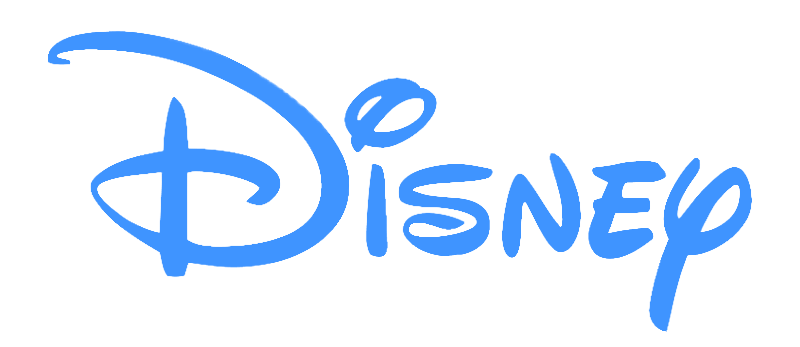
# **Disney Animated Movies Classifier - Transfer Learning**

## *Data Collection*

In [ ]:
!pip install bing-image-downloader

In [ ]:
!mkdir data

In [ ]:
from bing_image_downloader import downloader

In [ ]:
animated_movies = (
    "Toy Story",
    "Frozen",
    "Coco",
    "Encanto",
    "Finding Dory",
    "Finding Nemo",
    "Wreck It Ralph",
    "Ralph Breaks The Internet",
    "Zootopia",
    "Moana",
    "Elemental",
    "Inside Out"
)

In [ ]:
for movie in animated_movies:
  downloader.download("Disney's " + movie, limit = 500, output_dir = "data")

[%] Downloading Images to /content/data/Disney's Toy Story


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://thatshelf.com/wp-content/uploads/2019/06/Toy-Story-4-Featured.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://vignette3.wikia.nocookie.net/disney/images/1/13/Toy_Story.jpg/revision/latest?cb=20151003163558
[%] File Downloaded !

[%] Downloading Image #3 from https://pictures.abebooks.com/TUOSIST/14243530913.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://www.numericapac.org/wp-content/uploads/2018/01/Movie_ToyStory.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://originalvintagemovieposters.com/wp-content/uploads/2020/02/TOY-STORY-9045-scaled.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://www.fodors.com/wp-content/uploads/2018/07/Disney-Toy-Story-Land-Hero.jpg
[%] File Downloaded !

[%] Downloading Image #7 from http://2.bp.blogspot.com/-fakccITKWfo/TVnecs3UUcI/AAAAAA

## *Data Processing & Augmentation*

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(size = (250, 250)),
        transforms.RandomRotation(degrees = (-45, 45)),
        transforms.ToTensor(),

        transforms.Normalize(
            mean = (0.5, 0.5, 0.5),
            std = (0.5, 0.5, 0.5)
        )
    ]
)

In [ ]:
image_folder = datasets.ImageFolder(
    root = "data",
    transform = transform
)

In [ ]:
image_folder

Dataset ImageFolder
    Number of datapoints: 408
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(250, 250), interpolation=bilinear, max_size=None, antialias=warn)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## *Labels*

In [ ]:
labels = image_folder.class_to_idx
labels

{"Disney's Coco": 0,
 "Disney's Elemental": 1,
 "Disney's Encanto": 2,
 "Disney's Finding Dory": 3,
 "Disney's Finding Nemo": 4,
 "Disney's Frozen": 5,
 "Disney's Moana": 6,
 "Disney's Ralph Breaks The Internet": 7,
 "Disney's Toy Story": 8,
 "Disney's Wreck It Ralph": 9,
 "Disney's Zootopia": 10}

In [ ]:
idx_to_class = {value : key for value, key in zip(labels.values(), labels.keys())}
idx_to_class

{0: "Disney's Coco",
 1: "Disney's Elemental",
 2: "Disney's Encanto",
 3: "Disney's Finding Dory",
 4: "Disney's Finding Nemo",
 5: "Disney's Frozen",
 6: "Disney's Moana",
 7: "Disney's Ralph Breaks The Internet",
 8: "Disney's Toy Story",
 9: "Disney's Wreck It Ralph",
 10: "Disney's Zootopia"}

## *Viewing A Few Images*

In [ ]:
from random import randint

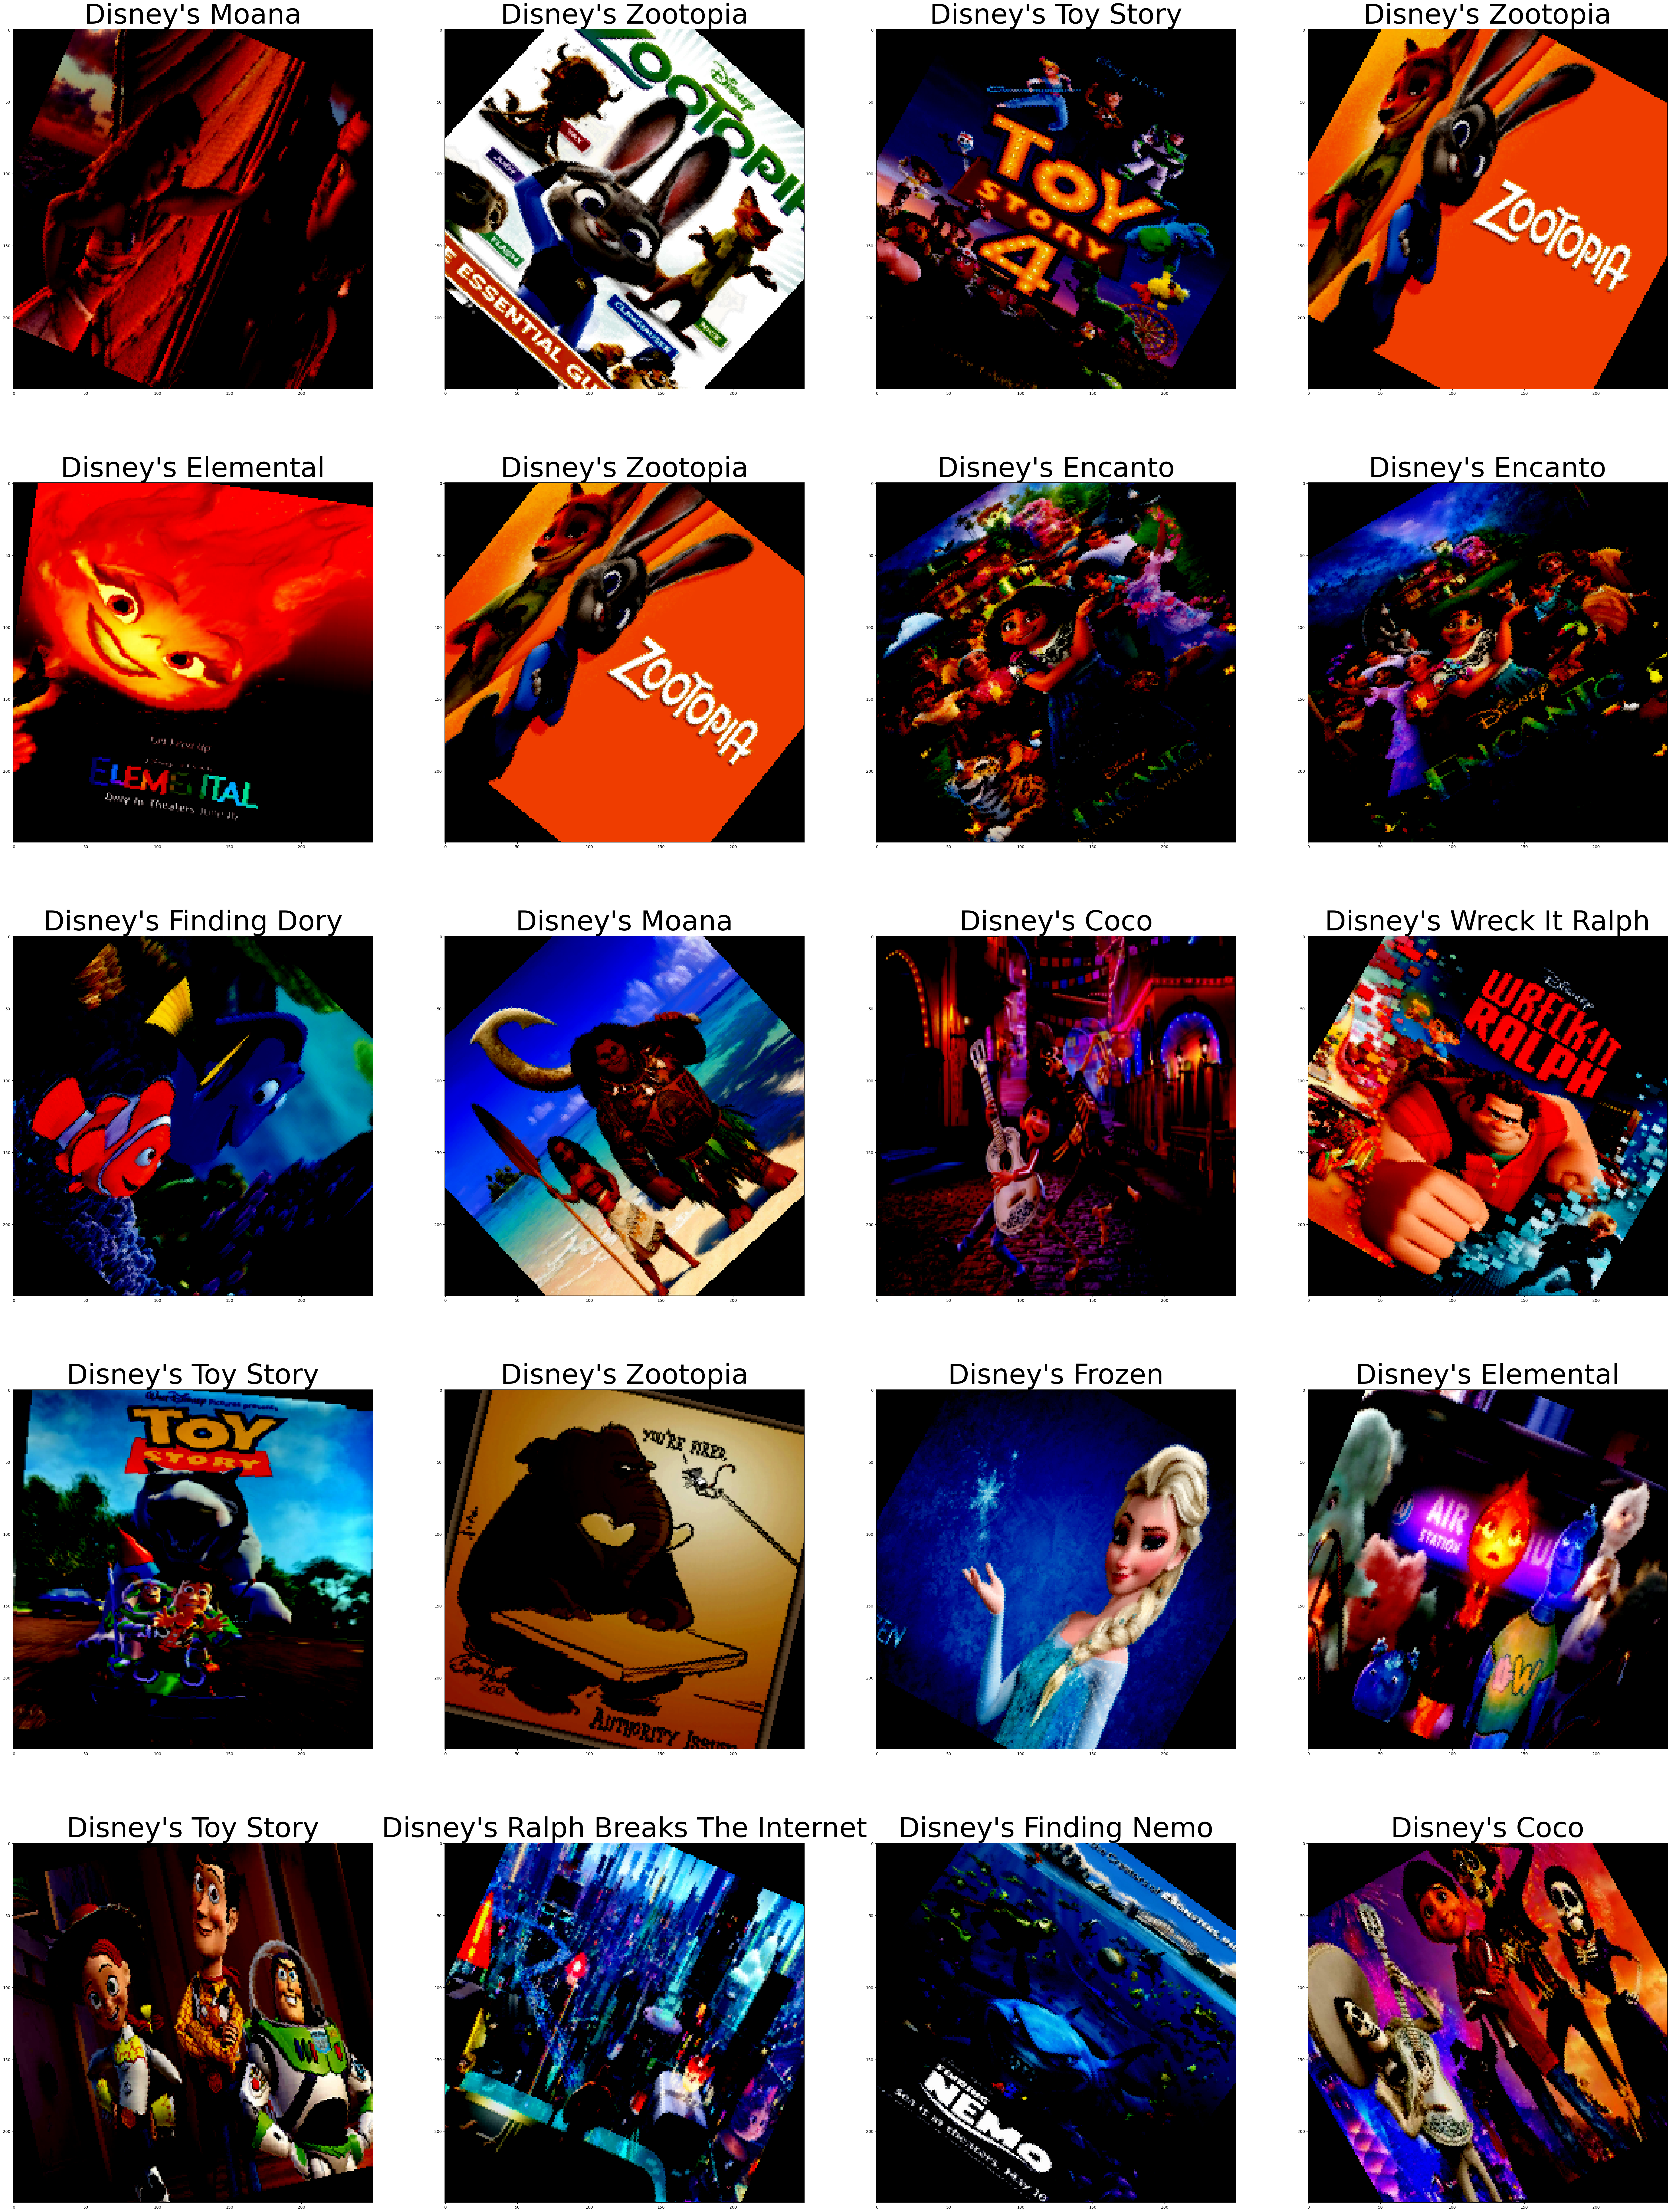

In [ ]:
fig = plt.figure(figsize = (75, 100))
num_of_images = 20

for i in range(num_of_images):
  image_num = randint(0, 400)

  fig.add_subplot(5, 4, i + 1)
  plt.imshow(image_folder[image_num][0].detach().numpy().transpose(1, 2, 0))
  plt.title(idx_to_class[image_folder[image_num][1]], fontdict = {"fontsize" : 70})

## *Splitting The Data Into Training & Testing Samples*

In [ ]:
from torch.utils.data import random_split
train_data, test_data = random_split(image_folder, lengths = (0.9, 0.1))

In [ ]:
print(f"Train Data : {len(train_data)}")
print(f"Test Data : {len(test_data)}")

Train Data : 368
Test Data : 40


In [ ]:
import torch
import torch.nn as nn

torch.manual_seed(42)

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size = 20,
    shuffle = True
)

test_loader = DataLoader(
    test_data,
    batch_size = 10,
    shuffle = True
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## **Transfer Learning - ResNet18**

In [ ]:
Model = models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for parameter in Model.parameters():
  parameter.requires_grad = False

In [ ]:
Model.fc = nn.Linear(512, 11)

In [ ]:
Model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## *Training*

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.001)

In [ ]:
import time

start_time = time.time()

epochs : int = 25
train_losses : int = []
train_acc : int = []
test_losses : int = [0]
test_acc : int = [0]

train_corr = 0
test_corr = 0

for epoch in range(epochs):

  Model.train()

  train_corr = 0

  for b, (x_train, y_train) in enumerate(train_loader):
    y_pred = Model(x_train.to(device))
    loss = loss_fn(y_pred, y_train.to(device))
    predicted = torch.max(y_pred.data, 1)[1]

    batch_corr : int = (predicted == y_train.to(device)).sum()
    train_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b + 1) % 5 == 0:
      print(f"Epoch : {epoch + 1}, Batch : {b + 1}, Test Loss : {test_losses[-1]}, Test Acc : {test_corr / len(test_data)}, Train Acc : {train_corr / len(train_data)}, Train Loss : {loss.item()}")

  train_losses.append(loss)
  train_acc.append(train_corr / len(train_data))

  Model.eval()

  test_corr = 0

  with torch.no_grad():
    for b, (x_test, y_test) in enumerate(test_loader):
      y_val = Model(x_test.to(device))
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test.to(device)).sum()

  loss = loss_fn(y_val, y_test.to(device))
  test_losses.append(loss)
  test_acc.append(test_corr / len(test_data))

current_time = time.time()
print(f"Time taken to train the model : {current_time - start_time} seconds!")

Epoch : 1, Batch : 5, Test Loss : 0, Test Acc : 0.0, Train Acc : 0.03804348036646843, Train Loss : 2.826627492904663
Epoch : 1, Batch : 10, Test Loss : 0, Test Acc : 0.0, Train Acc : 0.08967391401529312, Train Loss : 2.115459680557251
Epoch : 1, Batch : 15, Test Loss : 0, Test Acc : 0.0, Train Acc : 0.15760870277881622, Train Loss : 2.338189125061035
Epoch : 2, Batch : 5, Test Loss : 2.2725071907043457, Test Acc : 0.20000000298023224, Train Acc : 0.08152174204587936, Train Loss : 2.2312474250793457
Epoch : 2, Batch : 10, Test Loss : 2.2725071907043457, Test Acc : 0.20000000298023224, Train Acc : 0.16032609343528748, Train Loss : 1.8969138860702515
Epoch : 2, Batch : 15, Test Loss : 2.2725071907043457, Test Acc : 0.20000000298023224, Train Acc : 0.24184782803058624, Train Loss : 1.9933502674102783
Epoch : 3, Batch : 5, Test Loss : 1.9152389764785767, Test Acc : 0.375, Train Acc : 0.10597826540470123, Train Loss : 1.8569015264511108
Epoch : 3, Batch : 10, Test Loss : 1.9152389764785767, 

## *Evaluating The Model On Test Data*

In [ ]:
Model.eval()

correct = 0
y_testing = []
y_predicted = []

with torch.no_grad():
  for _, (x_test, y_test) in enumerate(test_loader):
    x_test, y_test = x_test.to(device), y_test.to(device)
    y_pred = torch.argmax(Model(x_test), 1)
    correct += (y_pred == y_test).sum()

    for i, j in zip(y_pred, y_test):
      y_predicted.append(i.cpu())
      y_testing.append(j.cpu())

print(f"Accuracy : {correct / len(test_data) * 100} %")

Accuracy : 80.0 %


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred = y_predicted, y_true = y_testing))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.33      1.00      0.50         1
           2       1.00      0.86      0.92         7
           3       1.00      0.67      0.80         3
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         3
           6       1.00      0.50      0.67         2
           7       1.00      0.80      0.89         5
           8       0.00      0.00      0.00         1
           9       0.50      1.00      0.67         1
          10       0.75      0.86      0.80         7

    accuracy                           0.80        40
   macro avg       0.73      0.75      0.70        40
weighted avg       0.83      0.80      0.80        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## *Evaluating The Model On Train Data*

In [192]:
Model.eval()

correct = 0
y_testing = []
y_predicted = []

with torch.no_grad():
  for _, (x_test, y_test) in enumerate(train_loader):
    x_test, y_test = x_test.to(device), y_test.to(device)
    y_pred = torch.argmax(Model(x_test), 1)
    correct += (y_pred == y_test).sum()

    for i, j in zip(y_pred, y_test):
      y_predicted.append(i.cpu())
      y_testing.append(j.cpu())

print(f"Accuracy : {correct / len(train_data) * 100} %")

Accuracy : 91.30435180664062 %


In [201]:
print(classification_report(y_pred = y_predicted, y_true = y_testing))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.91      0.98      0.94        42
           2       0.86      0.83      0.85        30
           3       0.92      0.82      0.87        28
           4       0.87      0.93      0.90        29
           5       0.97      1.00      0.99        35
           6       0.97      0.94      0.95        32
           7       0.88      0.85      0.87        27
           8       0.96      0.89      0.92        27
           9       0.79      0.79      0.79        28
          10       0.95      0.97      0.96        60

    accuracy                           0.91       368
   macro avg       0.91      0.90      0.90       368
weighted avg       0.91      0.91      0.91       368



## *Plotting Predictions*

In [188]:
Model.eval()
fig = plt.figure(figsize = (75, 100))

for i in range(20):
    fig.add_subplot(5, 4, i + 1)
    plt.imshow(test_loader.dataset[i][0].detach().numpy().transpose(1, 2, 0))

    with torch.no_grad():
        y_pred = torch.argmax(Model(test_loader.dataset[i][0].unsqueeze(0).to(device)).data, 1)
        y_pred_text = f"Actual Value : {idx_to_class[test_loader.dataset[i][1]][9:]}\nPredicted : {idx_to_class[int(y_pred.cpu()[0])][9:]}"

    plt.title(y_pred_text, fontdict = {"fontsize" : 75})

## *Saving The Model*

In [ ]:
torch.save(Model.state_dict(), "Disney-Movie-Classifier-CNN.pt")